In [19]:
import os
import scipy
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from scipy import signal
from matplotlib import pyplot as plt
from dataloader import TestCase

601


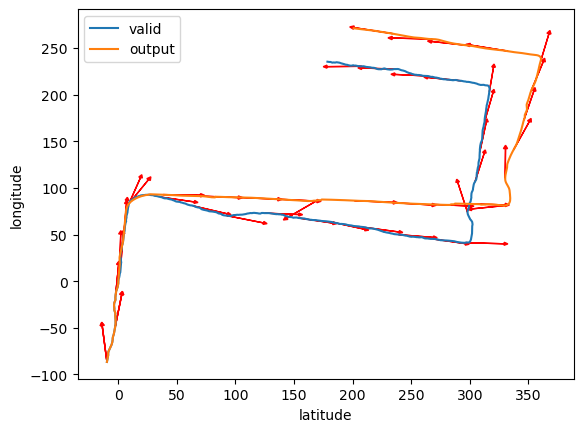

In [20]:
tc = TestCase('test_case0')
# tc = TestCase('test_case1')
# tc = TestCase('../TestSet/test2')
# tc = TestCase('../TestSet/test5')
# tc = TestCase('../TestSet/test7')
# tc = TestCase('../TestSet/test10')
# tc = TestCase('../TestSet/test11')
# tc = TestCase('../Dataset-of-Pedestrian-Dead-Reckoning/Hand-Walk/Hand-Walk-02-005')
# tc = TestCase('../Dataset-of-Pedestrian-Dead-Reckoning/Hand-Walk/Hand-Walk-02-003')
# tc = TestCase('../Dataset-of-Pedestrian-Dead-Reckoning/Pocket-Ride/Pocket-Ride-03-001')
# tc = TestCase('../Dataset-of-Pedestrian-Dead-Reckoning/HandSwing-Walk/HandSwing-Walk-07-001')
# tc = tc.slice(10, 60)
print(len(tc.time_location))
tc.draw_route()

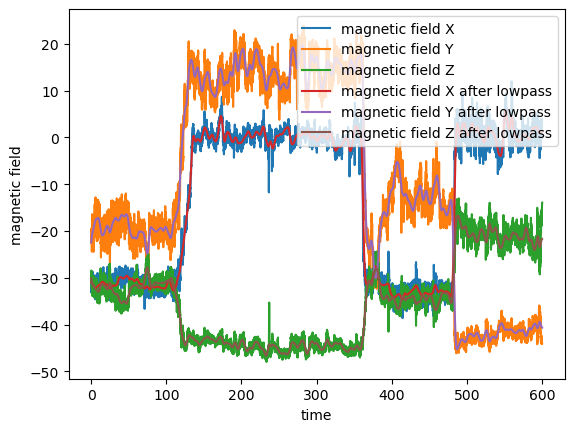

In [21]:
# 画出磁场方向
plt.plot(tc.time, tc.m_x, label='magnetic field X')
plt.plot(tc.time, tc.m_y, label='magnetic field Y')
plt.plot(tc.time, tc.m_z, label='magnetic field Z')
# 低通滤波
# TODO: 调节参数 Wn : array_like
#       The critical frequency or frequencies.
b, a = signal.butter(2, 0.005, 'lowpass')
m_x = signal.filtfilt(b, a, tc.m_x)
m_y = signal.filtfilt(b, a, tc.m_y)
m_z = signal.filtfilt(b, a, tc.m_z)
m = np.array([m_x, m_y, m_z])
m = m.T
plt.plot(tc.time, m_x, label='magnetic field X after lowpass')
plt.plot(tc.time, m_y, label='magnetic field Y after lowpass')
plt.plot(tc.time, m_z, label='magnetic field Z after lowpass')
plt.xlabel('time')
plt.ylabel('magnetic field')
plt.legend()
plt.show()

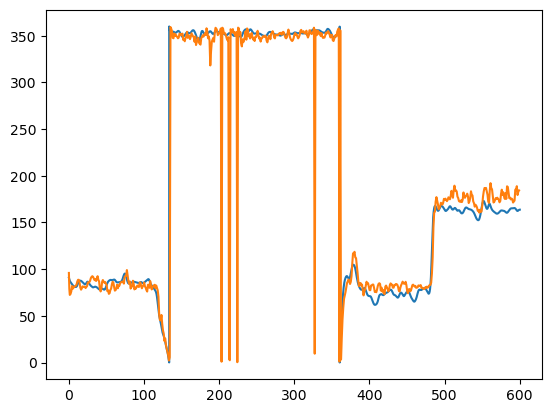

In [22]:
# 对 a 求平均得到重力加速度
g_x = np.mean(tc.a_x)
g_y = np.mean(tc.a_y)
g_z = np.mean(tc.a_z)
g = np.array([g_x, g_y, g_z])
# 通过磁场方向和重力加速度叉乘得到东向量
e = np.cross(m, g)
# 前 10% 个东向量平均值作为初始东向量
e0 = np.mean(e[:50 * tc.len_input], axis=0)
# 前 10% 的 direction 的平均值作为初始 direction
direction0 = np.mean(tc.direction)
# 求出所有东向量和初始东向量的角度
angles = np.arccos(np.dot(e, e0) / (np.linalg.norm(e, axis=1) * np.linalg.norm(e0))) * 180 / np.pi
# e 和 e0 叉乘后与重力点乘得到符号
signs = - np.sign(np.dot(np.cross(e, e0), g))
# 方向等于角度加上 direction0
direction = signs * angles + direction0
# 取模 360
direction %= 360
plt.plot(tc.time, direction)
if tc.have_location_valid:
    plt.plot(tc.time_location, tc.direction_valid)
plt.show()

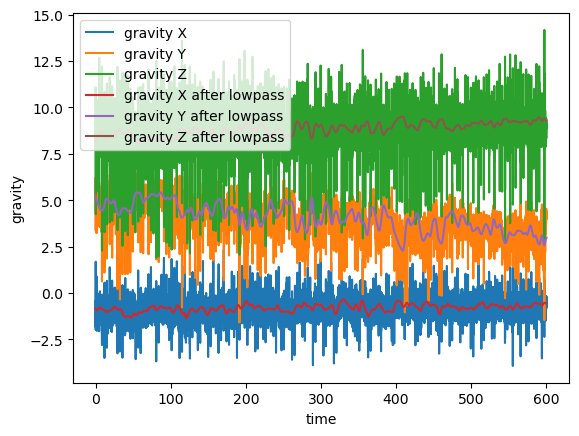

In [23]:
plt.plot(tc.time, tc.g_x, label='gravity X')
plt.plot(tc.time, tc.g_y, label='gravity Y')
plt.plot(tc.time, tc.g_z, label='gravity Z')
# 对 a 低通滤波得到重力加速度
g_x = signal.filtfilt(b, a, tc.g_x)
g_y = signal.filtfilt(b, a, tc.g_y)
g_z = signal.filtfilt(b, a, tc.g_z)
g = np.array([g_x, g_y, g_z])
g = g.T
# 画出重力加速度
plt.plot(tc.time, g_x, label='gravity X after lowpass')
plt.plot(tc.time, g_y, label='gravity Y after lowpass')
plt.plot(tc.time, g_z, label='gravity Z after lowpass')
plt.xlabel('time')
plt.ylabel('gravity')
plt.legend()
plt.show()

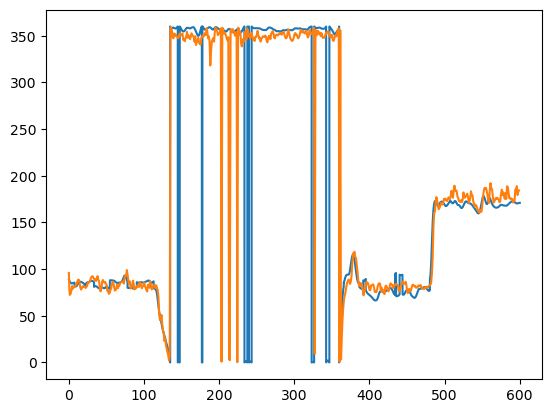

In [24]:
# 通过磁场方向和重力加速度叉乘得到东向量
e = np.cross(m, g)
# 前 10% 个东向量平均值作为初始东向量
e0 = np.mean(e[:50 * tc.len_input], axis=0)
# 前 10% 的 direction 的平均值作为初始 direction
direction0 = np.mean(tc.direction)
# 求出所有东向量和初始东向量的角度
angles = np.arccos(np.dot(e, e0) / (np.linalg.norm(e, axis=1) * np.linalg.norm(e0))) * 180 / np.pi
# e 和 e0 叉乘后与重力点乘得到符号
signs = - np.sign([np.dot(c, _g) for c, _g in zip(np.cross(e, e0), g)])
# 方向等于角度加上 direction0
direction = signs * angles + direction0
# 取模 360
direction %= 360
plt.plot(tc.time, direction)
if tc.have_location_valid:
    plt.plot(tc.time_location, tc.direction_valid)
plt.show()

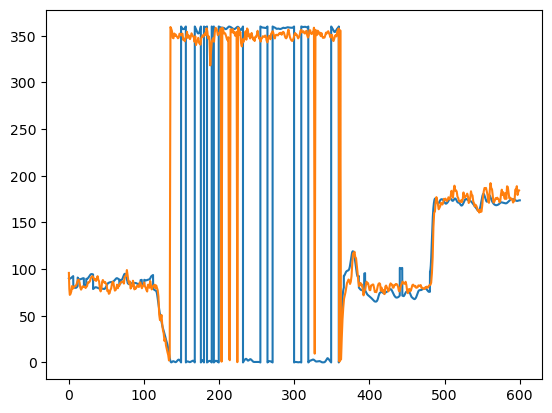

In [25]:
# 通过磁场方向和重力加速度叉乘得到东向量
e = np.cross(m, g)
# 第 10% 附近的 50 个东向量平均值作为初始东向量
size = len(tc.direction)
e0 = np.mean(e[50 * size - 50: 50 * size], axis=0)
# 第 10% 的 direction 作为初始 direction
direction0 = np.mean(tc.direction[-1])
# 求出所有东向量和初始东向量的角度
angles = np.arccos(np.dot(e, e0) / (np.linalg.norm(e, axis=1) * np.linalg.norm(e0))) * 180 / np.pi
# e 和 e0 叉乘后与重力点乘得到符号
signs = - np.sign([np.dot(c, _g) for c, _g in zip(np.cross(e, e0), g)])
# 方向等于角度加上 direction0
direction = signs * angles + direction0
# 取模 360
direction %= 360
plt.plot(tc.time, direction)
if tc.have_location_valid:
    plt.plot(tc.time_location, tc.direction_valid)
plt.show()

direction0 = 83.04131999757827


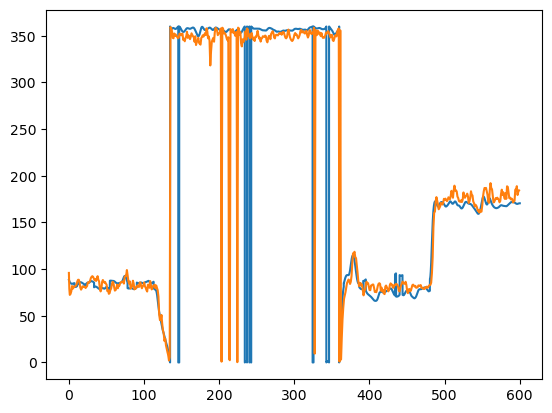

In [26]:
def direction_diff(a, b):
    a = a % 360
    b = b % 360
    abs1 = np.abs(a - b)
    abs2 = 360 - abs1
    return np.where(abs1 < abs2, abs1, abs2)

# 通过磁场方向和重力加速度叉乘得到东向量
e = np.cross(m, g)
# 取前 10% 个东向量平均值作为初始东向量
size = tc.len_input * 50
e0 = np.mean(e[:size], axis=0)
# 求出所有东向量和初始东向量的角度
angles = np.arccos(np.dot(e, e0) / (np.linalg.norm(e, axis=1) * np.linalg.norm(e0))) * 180 / np.pi
# e 和 e0 叉乘后与重力点乘得到符号
signs = - np.sign([np.dot(c, _g) for c, _g in zip(np.cross(e, e0), g)])
# 输入的正确的前 10% 数据
direction_valid = tc.direction
# 每隔 50 取一次平均得到预测的前 10% 数据 (无初始值偏移量)
direction_offset = []
for i in range(0, size, 50):
    direction_offset.append(np.mean((signs * angles)[i: i + 50]))
direction_offset = np.array(direction_offset)
# 平均误差
error_fn = lambda x: np.mean(direction_diff(direction_valid, (direction_offset + x)))
# 最小化误差获取最佳初始值
direction0 = scipy.optimize.minimize(error_fn, 0).x[0]
print(f"{direction0 = }")
# 方向等于角度加上 direction0
direction = signs * angles + direction0
# 取模 360
direction %= 360
direction_pred = direction
plt.plot(tc.time, direction)
if tc.have_location_valid:
    plt.plot(tc.time_location, tc.direction_valid)
plt.show()

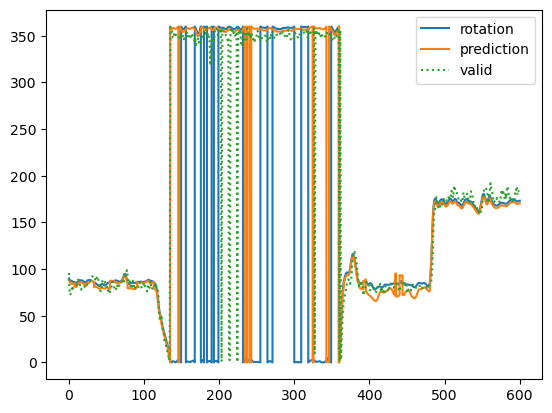

In [27]:
def get_rotation_matrix(a, b):
    '''
    get rotation matrix from two unit vectors

    a.shape = (3,)
    
    b.shape = (3,)

    b = R @ a
    
    return R
    '''
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    return np.eye(3) + vx + vx @ vx * (1 - c) / s ** 2

def get_rotation_matrixes(a, b):
    '''
    get rotation matrix from two unit vectors

    a.shape = (3,)
    
    b.shape = (n, 3)

    b = R @ a
    
    return R
    '''
    return np.array([get_rotation_matrix(a, b[i]) for i in range(len(b))])

def get_reverse_rotation_matrixes(R):
    return np.array([R[i].T for i in range(len(R))])

# 通过磁场方向和重力加速度叉乘得到东向量
e = np.cross(m, g)
# 将 g 和 e 变为单位向量
g = g / np.linalg.norm(g, axis=1).reshape(-1, 1)
e = e / np.linalg.norm(e, axis=1).reshape(-1, 1)
# 第 10% 附近的 50 个重力向量平均值作为初始重力
size = len(tc.direction)
g0 = np.mean(g[50 * size - 50: 50 * size], axis=0)
# 第 10% 附近的 50 个东向量平均值作为初始东向量
e0 = np.mean(e[50 * size - 50: 50 * size], axis=0)
# 第 10% 的 direction 作为初始 direction
direction0 = np.mean(tc.direction[-1])
# 求出 g0 到 g 的旋转矩阵
R = get_rotation_matrixes(g0, g)
# 求出逆旋转矩阵
R_inv = get_reverse_rotation_matrixes(R)
# 通过 R_inv 和 e 相乘将其旋转回 g0 为基准的坐标轴
e = np.array([R_inv[i] @ e[i] for i in range(len(e))])
# 求出所有东向量和初始东向量的角度
angles = np.arccos(np.dot(e, e0)) * 180 / np.pi
# e 和 e0 叉乘后与重力点乘得到符号
signs = - np.sign([np.dot(c, _g) for c, _g in zip(np.cross(e, e0), g)])
# 方向等于角度加上 direction0
direction = signs * angles + direction0
# 取模 360
direction %= 360
plt.plot(tc.time, direction, label="rotation")
plt.plot(tc.time, direction_pred, label="prediction")
if tc.have_location_valid:
    plt.plot(tc.time_location, tc.direction_valid, ls=':', label="valid")
else:
    plt.plot(tc.time_location[:tc.len_input], tc.direction, ls=':', label="valid")
plt.legend()
plt.show()